Universidade Federal de Alagoas

IC - Instituto de Computação

 

# Processamento de linguagem natural - 2020.1
**Professor**: Thales Vieira

**Alunos**: Hugo Tallys Martins Oliveira e Valério Nogueira Rodrigues Júnior


## 5ª lista de exercícios

---

# Pré-processamento dos dados

In [1]:
import re
import time
import umap
import nltk
import numpy
import pandas
import random

from bokeh.plotting import figure
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from bokeh.palettes import Category20
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from IPython.display import HTML, display
from bokeh.io import output_notebook, show
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

c:\users\hugog\ecom063-pln\env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
output_notebook() # Necessário para visualizar os gráficos com bokeh

Loading BokehJS ...

In [3]:
nltk.download('stopwords'); nltk.download('rslp'); nltk.download('punkt');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\hugog\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
bbc_dataset_url = 'data/bbc.csv'
cnn_dataset_url = 'data/cnn.csv'

dataset = pandas.concat([pandas.read_csv(dataset_url, sep='|') for dataset_url in [bbc_dataset_url, cnn_dataset_url]], ignore_index=True)
dataset = dataset.dropna(axis=0).reset_index(drop=True)

In [5]:
dataset.text = dataset.text.apply(lambda text: text.replace('\n', ' ')) # Remoção das quebras de linha
dataset.title = dataset.title.apply(lambda text: text.replace('\n', ' '))

In [6]:
def remove_boilerplate(text):
    boilerplate = ['Compartilhe este post com Email Facebook Messenger Messenger Twitter WhatsApp LinkedIn Copiar este link Estes são links externos e abrirão numa nova janela', 'Já assistiu aos nossos novos vídeos no YouTube? Inscreva-se no nosso canal!', 'Final de YouTube post  de BBC News Brasil Final de YouTube post 2 de BBC News Brasil Final de YouTube post 3 de BBC News Brasil']
    
    for b in boilerplate:
        text = text.replace(b, '')
    return text

dataset.text = dataset.text.apply(remove_boilerplate) # Remoção de fragmentos irrelevantes do texto que se repetem

In [7]:
def preprocess(text):
    text = re.sub(r'\w*\d\w*', '', text) # Remove todas as palavras que contém números
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ ]', '', text.lower()) # Remove pontuação e converte para minúscula
    return re.sub(r'\s+', ' ', text) # Remove espaços repetidos

dataset['processed_text'] = dataset.text.apply(preprocess)
dataset['processed_title'] = dataset.title.apply(preprocess)

In [8]:
stopwords = nltk.corpus.stopwords.words('portuguese')

def tokenize_remove_stopwords(text):
    tokenized_text = nltk.word_tokenize(text, language='portuguese')
    return " ".join([token for token in tokenized_text if token not in stopwords])

dataset.processed_text = dataset.processed_text.apply(tokenize_remove_stopwords) # Tokeniza o texto e remove stopwords
dataset.processed_title = dataset.processed_title.apply(tokenize_remove_stopwords) # Tokeniza o titulo e remove stopwords

In [9]:
dataset

,url,title,text,processed_text,processed_title
0,https://www.bbc.co.uk/portuguese/brasil-53020785,Coronavírus: pandemia pode jogar até 14 milhõe...,A turbulência econômica causada pela pandemi...,turbulência econômica causada pandemia novo co...,coronavírus pandemia pode jogar milhões brasil...
1,https://www.bbc.co.uk/portuguese/brasil-53027318,Coronavírus: como funcionam as duas vacinas co...,Cerca de 11 mil voluntários brasileiros vão ...,cerca mil voluntários brasileiros vão receber ...,coronavírus funcionam duas vacinas contra covi...
2,https://www.bbc.co.uk/portuguese/brasil-51713943,Coronavírus: Brasil passa o Reino Unido e se t...,*atualizada às 18h20 de 12 de junho de 2020 ...,atualizada s junho brasil totalizou nesta sext...,coronavírus brasil passa reino unido torna seg...
3,https://www.bbc.co.uk/portuguese/internacional...,Coronavírus na Índia: com lockdown 'insustentá...,"Quando, em 24 de março, o governo indiano in...",março governo indiano iniciou estrito isolamen...,coronavírus índia lockdown insustentável índia...
4,https://www.bbc.co.uk/portuguese/internacional...,2ª onda do coronavírus? Irã vê aumento acelera...,O Irã registrou um rápido aumento no número ...,irã registrou rápido aumento número casos covi...,onda coronavírus irã vê aumento acelerado após...
...,...,...,...,...,...
1611,https://www.cnnbrasil.com.br/saude/2020/02/27/...,Farmácias têm falta de máscaras após confirmaç...,Com a confirmação do primeiro caso de contamin...,confirmação primeiro caso contaminação novo co...,farmácias têm falta máscaras após confirmação ...
1612,https://www.cnnbrasil.com.br/business/2020/02/...,Ibovespa tem nova queda com mercado ainda preo...,Preocupações com a propagação do novo coronaví...,preocupações propagação novo coronavírus poten...,ibovespa nova queda mercado ainda preocupado c...
1613,https://www.cnnbrasil.com.br/internacional/202...,Japonesa testa positivo pela segunda vez para ...,TÓQUIO - Uma guia de ônibus turístico no Japão...,tóquio guia ônibus turístico japão apresentou ...,japonesa testa positivo segunda vez coronavírus
1614,https://www.cnnbrasil.com.br/saude/2020/02/26/...,Primeiro brasileiro com coronavírus tem sintom...,O primeiro brasileiro com diagnóstico confir...,primeiro brasileiro diagnóstico confirmado cor...,primeiro brasileiro coronavírus sintomas brand...


# Buscador de documentos - Word2vec

Desenvolver um buscador de documentos:

1. Escolha e aplique um modelo do tipo _word2vec_ a seus textos, compatível com o idioma escolhido (inglês ou português).
2. Escolha 5 palavras de consulta que não estão em nenhum dos textos. Para cada palavra de consulta, encontre as 3 palavras __de seu conjunto de textos__ mais parecidas com cada uma das palavras de consulta e exiba os documentos onde estas palavras aparecem.
3. Usando as mesmas palavras do item acima, recupere os 3 documentos cujo _word vector_ médio é mais próximo de cada palavra de consulta.
4. Realize o procedimento acima usando três modelos com dimensão distinta.

Primeiro vamos determinar o vocabulário do nosso dataset (__corpo do documento__ e __título do documento__):

In [10]:
def get_vocab(texts):
    vocab = ' '.join([text for text in texts])
    return sorted(set(vocab.split(' ')))

processed_texts_vocab = get_vocab(dataset.processed_text.values)
processed_titles_vocab = get_vocab(dataset.processed_title.values)

Sorteando 5 palavras aleatoriamente do vocabulário de títulos:

In [11]:
search_words = random.sample(processed_titles_vocab, 5)
search_words

['partir', 'trad', 'trump', 'japonês', 'morto']

Para determinar as palavras mais parecidas a cada palavra de busca selecionada vamos utilizar os seguintes modelos pré-treinados em português:

* CBOW 100
* SKIPGRAM 100
* SKIPGRAM 300

A descrição completa do modelo pré-treinado _word2vec_ pode ser encontrada no link:

> http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

In [12]:
CBOW_100 = 'C:/Users/hugog/Documents/word2vec/cbow_s100.txt'
SKIP_GRAM_100 = 'C:/Users/hugog/Documents/word2vec/skip_s100.txt'
SKIP_GRAM_300 = 'C:/Users/hugog/Documents/word2vec/skip_s100.txt'

MODEL_LIST = [('CBOW_100', CBOW_100), ('SKIP_GRAM_100', SKIP_GRAM_100), ('SKIP_GRAM_300', SKIP_GRAM_300)]

Encontrando lista de palavras mais similares para cada modelo:

In [13]:
def get_most_similar_words(search_word, n):
    most_similar = []
    for word in processed_texts_vocab:
        try:
            similarity = embedding.similarity(word, search_word)
        except:
            similarity = -1
        most_similar.append(similarity)
    most_similar = numpy.argsort(most_similar)[-(n+1):-1]
    most_similar = most_similar[::-1]
    return [processed_texts_vocab[i] for i in most_similar]

most_similar_words = {}
for model_name, model_path in MODEL_LIST:
    print('\nCarregando o modelo %s' % model_name)
    embedding = KeyedVectors.load_word2vec_format(model_path)
    print('Calculando palavras mais similares')
    most_similar_words[model_name] = []
    for search_word in search_words:
        sim_search_word = get_most_similar_words(search_word, 3)
        print(f'\t{search_word} -> {str(sim_search_word)}')
        most_similar_words[model_name].append({'search_word': search_word, 'similar_words': sim_search_word})


Carregando o modelo CBOW_100
Calculando palavras mais similares
	partir -> ['despeito', 'realização', 'bordo']
	trad -> ['cf', 'r', 'doe']
	trump -> ['trumpo', 'madero', 'pato']
	japonês -> ['francês', 'alemão', 'romeno']
	morto -> ['assassinado', 'preso', 'detido']

Carregando o modelo SKIP_GRAM_100
Calculando palavras mais similares
	partir -> ['despeito', 'incorporação', 'reabertura']
	trad -> ['mandetta', 'beozzo', 'ba']
	trump -> ['hillary', 'sanders', 'clinton']
	japonês -> ['chinês', 'coreano', 'tailandês']
	morto -> ['assassinado', 'estrangulado', 'resgatado']

Carregando o modelo SKIP_GRAM_300
Calculando palavras mais similares
	partir -> ['despeito', 'incorporação', 'reabertura']
	trad -> ['mandetta', 'beozzo', 'ba']
	trump -> ['hillary', 'sanders', 'clinton']
	japonês -> ['chinês', 'coreano', 'tailandês']
	morto -> ['assassinado', 'estrangulado', 'resgatado']


Dado o __modelo__ e a __palavra de busca__ recuperamos alguns documentos que cotenham as palavras mais semelhantes encontradas no item anterior:

In [16]:
def get_word_list(model_name, search_word):
    for word_list in most_similar_words[model_name]:
        if search_word == word_list['search_word']:
            return word_list['similar_words']

def fetch_documents(word_list):
    dataframes = []
    for word in word_list:
        df = dataset[dataset.processed_text.apply(lambda text: word in text.split(' '))]
        dataframes.append(df[['url', 'title']])
    return pandas.concat(dataframes).drop_duplicates().reset_index(drop=True)        

for model_name, model_path in MODEL_LIST:
    for search_word in search_words:
        word_list = get_word_list(model_name=model_name, search_word=search_word)
        search_documents = fetch_documents(word_list)
        display(HTML(f'<h3>Modelo [{model_name}]<br><br>Palavra Busca [{search_word}]<br><br>Palavras Similares {word_list}</h3>'))
        display(HTML(search_documents.head().to_html()))

,url,title
0,https://www.bbc.co.uk/portuguese/internacional-53008262,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil"
1,https://www.bbc.co.uk/portuguese/geral-52806209,Cloroquina contra coronavírus: por que OMS decidiu interromper testes com remédio em pacientes com covid-19 - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/brasil-52610097,"'Presidente dá cambalhota e ele mesmo escorrega', diz FHC sobre atuação de Bolsonaro na pandemia do novo coronavírus - BBC News Brasil"
3,https://www.bbc.co.uk/portuguese/brasil-52357879,Coronavírus: uso de dados de geolocalização contra a pandemia põe em risco sua privacidade? - BBC News Brasil
4,https://www.cnnbrasil.com.br/politica/2020/03/30/em-dois-dias-stf-recebe-mais-67-acoes-sobre-o-coronavirus,"Em dois dias, STF recebe mais 81 ações sobre o coronavírus"


,url,title
0,https://www.cnnbrasil.com.br/politica/2020/03/19/eduardo-bolsonaro-nega-ter-ofendido-china-ao-culpar-pais-pelo-novo-coronavirus,Eduardo Bolsonaro nega ter ofendido China ao culpar país pelo novo coronavírus
1,https://www.bbc.co.uk/portuguese/brasil-53020785,"Coronavírus: pandemia pode jogar até 14 milhões de brasileiros na pobreza, diz estudo - BBC News Brasil"
2,https://www.bbc.co.uk/portuguese/internacional-53008262,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil"
3,https://www.bbc.co.uk/portuguese/brasil-52856552,"Coronavírus: motoristas de aplicativo trocam passageiros por pets, entregas de mercados e refeições - BBC News Brasil"
4,https://www.bbc.co.uk/portuguese/internacional-52921925,Lockdown na Índia: como a quarentena matou mais de 300 pessoas que não tinham o coronavírus - BBC News Brasil


,url,title
0,https://www.cnnbrasil.com.br/internacional/2020/04/22/eua-missouri-processa-china-por-perdas-economicas-causadas-pelo-coronavirus,EUA: Missouri processa China por 'perdas econômicas' causadas pelo coronavírus
1,https://www.cnnbrasil.com.br/nacional/2020/03/24/dono-do-madero-e-presidente-de-sindicado-debatem-sobre-acoes-contra-coronavirus,Dono do Madero e presidente de sindicato debatem sobre ações contra coronavírus
2,https://www.cnnbrasil.com.br/saude/2020/04/10/o-significado-por-tras-dos-sonhos-estranhos-durante-a-pandemia-do-coronavirus,O significado por trás dos sonhos estranhos durante a pandemia do coronavírus


,url,title
0,https://www.bbc.co.uk/portuguese/geral-52806075,Proteção contra o coronavírus: por que grupos defendem máscaras transparentes como padrão - BBC News Brasil
1,https://www.bbc.co.uk/portuguese/brasil-52741665,Coronavírus: o que diz o protocolo que libera cloroquina para casos leves no SUS - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/brasil-52595224,Coronavírus: Arthur Virgílio Neto chora ao citar agressões a coveiros e mortes - BBC News Brasil
3,https://www.bbc.co.uk/portuguese/brasil-52478247,Coronavírus: remédio para artrite tem resultados promissores contra covid-19 em pesquisa francesa - BBC News Brasil
4,https://www.bbc.co.uk/portuguese/brasil-52361730,Bolsonaro e Trump radicalizam: as semelhanças entre os líderes na pandemia de coronavírus - BBC News Brasil


,url,title
0,https://www.bbc.co.uk/portuguese/internacional-52480775,Coronavírus: 'O assassino do meu filho não merece morrer de covid-19 na cadeia' - BBC News Brasil
1,https://www.bbc.co.uk/portuguese/brasil-52943574,"Coronavírus: Falta de empatia de Bolsonaro com mortes por covid-19 parece psicopatia, diz psicanalista Maria Rita Kehl - BBC News Brasil"
2,https://www.bbc.co.uk/portuguese/internacional-52768908,Coronavírus: o crescente desespero de milhares de funcionários confinados em cruzeiros há meses - BBC News Brasil
3,https://www.bbc.co.uk/portuguese/internacional-53036253,Manifestantes vão às ruas proteger estátuas visadas por antirracistas e se chocam com policiais em Londres - BBC News Brasil
4,https://www.bbc.co.uk/portuguese/brasil-52610097,"'Presidente dá cambalhota e ele mesmo escorrega', diz FHC sobre atuação de Bolsonaro na pandemia do novo coronavírus - BBC News Brasil"


,url,title
0,https://www.bbc.co.uk/portuguese/internacional-53008262,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil"
1,https://www.bbc.co.uk/portuguese/geral-52806209,Cloroquina contra coronavírus: por que OMS decidiu interromper testes com remédio em pacientes com covid-19 - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/brasil-52610097,"'Presidente dá cambalhota e ele mesmo escorrega', diz FHC sobre atuação de Bolsonaro na pandemia do novo coronavírus - BBC News Brasil"
3,https://www.bbc.co.uk/portuguese/brasil-52357879,Coronavírus: uso de dados de geolocalização contra a pandemia põe em risco sua privacidade? - BBC News Brasil
4,https://www.cnnbrasil.com.br/politica/2020/03/30/em-dois-dias-stf-recebe-mais-67-acoes-sobre-o-coronavirus,"Em dois dias, STF recebe mais 81 ações sobre o coronavírus"


,url,title
0,https://www.bbc.co.uk/portuguese/brasil-53002123,"Coronavírus: Brasil pode se tornar país com mais mortos em 29/7 se nada mudar, diz projeção usada pela Casa Branca - BBC News Brasil"
1,https://www.bbc.co.uk/portuguese/brasil-52855085,Coronavírus: o site que mostra se você mora em área de risco de covid-19 - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/internacional-52779245,Como a América do Sul se tornou o novo epicentro da pandemia de coronavírus - BBC News Brasil
3,https://www.bbc.co.uk/portuguese/brasil-52782897,"Nas quase 2h de reunião sobre pandemia, Bolsonaro e ministros falam de coronavírus por 19 minutos - BBC News Brasil"
4,https://www.bbc.co.uk/portuguese/brasil-52732621,"Coronavírus: Brasil vai se tornar 'Coreia do Norte em questões sanitárias', diz pesquisador - BBC News Brasil"


,url,title
0,https://www.cnnbrasil.com.br/internacional/2020/03/17/mesmo-com-pandemia-de-coronavirus-democratas-mantem-primarias-em-3-estados,"Mesmo com pandemia de coronavírus, democratas mantêm primárias em 3 estados"
1,https://www.cnnbrasil.com.br/internacional/2020/03/19/por-coronavirus-estado-de-connecticut-adia-primarias-democratas-para-junho,"Por coronavírus, estado de Connecticut adia primárias democratas para junho"
2,https://www.cnnbrasil.com.br/internacional/2020/03/16/governador-de-ohio-quer-adiar-primarias-democratas-por-coronavirus,Governador de Ohio quer adiar primárias democratas em razão do coronavírus
3,https://www.cnnbrasil.com.br/nacional/2020/03/16/impactos-do-coronavirus-caso-grave-no-rj-e-mais-da-tarde-de-16-de-marco,"Impactos do coronavírus, caso grave no RJ e mais da tarde de 16 de março"
4,https://www.cnnbrasil.com.br/nacional/2020/03/16/bolsonaro-coronavirus-e-mais-noticias-da-manha-de-16-de-marco,"Divergências entre poderes, coronavírus e mais notícias da manhã de 16 de março"


,url,title
0,https://www.bbc.co.uk/portuguese/internacional-52983258,Coronavírus na China: Imagens de satélite indicam que covid-19 pode ter começado a se espalhar mais cedo em Wuhan - BBC News Brasil
1,https://www.bbc.co.uk/portuguese/geral-52967280,Coronavírus: o que os cientistas já descobriram sobre a covid-19 nos seus 6 primeiros meses - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/brasil-52975877,"Coronavírus: em 3 pontos, o que o Brasil pode perder no cenário internacional ao omitir dados de covid-19 - BBC News Brasil"
3,https://www.bbc.co.uk/portuguese/internacional-52889944,Coronavírus: o mistério de ‘disseminadores silenciosos’ que espalham a covid-19 - BBC News Brasil
4,https://www.bbc.co.uk/portuguese/internacional-52830618,Quarentenas funcionam para combater o coronavírus? Veja o que dizem os estudos - BBC News Brasil


,url,title
0,https://www.bbc.co.uk/portuguese/internacional-52480775,Coronavírus: 'O assassino do meu filho não merece morrer de covid-19 na cadeia' - BBC News Brasil
1,https://www.cnnbrasil.com.br/business/2020/05/29/pib-coronavirus-coloca-brasil-em-recessao-e-retomada-deve-ser-lenta,PIB: Coronavírus coloca Brasil em recessão e retomada deve ser lenta
2,https://www.bbc.co.uk/portuguese/internacional-52366530,Coronavírus: países latino-americanos usam dinheiro apreendido do narcotráfico e da corrupção para combater covid-19 - BBC News Brasil
3,https://www.cnnbrasil.com.br/saude/2020/03/20/cloroquina-entenda-por-que-voce-nao-deve-usar-o-remedio-contra-coronavirus,Cloroquina: entenda por que você não deve usar o remédio contra coronavírus


,url,title
0,https://www.bbc.co.uk/portuguese/internacional-53008262,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil"
1,https://www.bbc.co.uk/portuguese/geral-52806209,Cloroquina contra coronavírus: por que OMS decidiu interromper testes com remédio em pacientes com covid-19 - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/brasil-52610097,"'Presidente dá cambalhota e ele mesmo escorrega', diz FHC sobre atuação de Bolsonaro na pandemia do novo coronavírus - BBC News Brasil"
3,https://www.bbc.co.uk/portuguese/brasil-52357879,Coronavírus: uso de dados de geolocalização contra a pandemia põe em risco sua privacidade? - BBC News Brasil
4,https://www.cnnbrasil.com.br/politica/2020/03/30/em-dois-dias-stf-recebe-mais-67-acoes-sobre-o-coronavirus,"Em dois dias, STF recebe mais 81 ações sobre o coronavírus"


,url,title
0,https://www.bbc.co.uk/portuguese/brasil-53002123,"Coronavírus: Brasil pode se tornar país com mais mortos em 29/7 se nada mudar, diz projeção usada pela Casa Branca - BBC News Brasil"
1,https://www.bbc.co.uk/portuguese/brasil-52855085,Coronavírus: o site que mostra se você mora em área de risco de covid-19 - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/internacional-52779245,Como a América do Sul se tornou o novo epicentro da pandemia de coronavírus - BBC News Brasil
3,https://www.bbc.co.uk/portuguese/brasil-52782897,"Nas quase 2h de reunião sobre pandemia, Bolsonaro e ministros falam de coronavírus por 19 minutos - BBC News Brasil"
4,https://www.bbc.co.uk/portuguese/brasil-52732621,"Coronavírus: Brasil vai se tornar 'Coreia do Norte em questões sanitárias', diz pesquisador - BBC News Brasil"


,url,title
0,https://www.cnnbrasil.com.br/internacional/2020/03/17/mesmo-com-pandemia-de-coronavirus-democratas-mantem-primarias-em-3-estados,"Mesmo com pandemia de coronavírus, democratas mantêm primárias em 3 estados"
1,https://www.cnnbrasil.com.br/internacional/2020/03/19/por-coronavirus-estado-de-connecticut-adia-primarias-democratas-para-junho,"Por coronavírus, estado de Connecticut adia primárias democratas para junho"
2,https://www.cnnbrasil.com.br/internacional/2020/03/16/governador-de-ohio-quer-adiar-primarias-democratas-por-coronavirus,Governador de Ohio quer adiar primárias democratas em razão do coronavírus
3,https://www.cnnbrasil.com.br/nacional/2020/03/16/impactos-do-coronavirus-caso-grave-no-rj-e-mais-da-tarde-de-16-de-marco,"Impactos do coronavírus, caso grave no RJ e mais da tarde de 16 de março"
4,https://www.cnnbrasil.com.br/nacional/2020/03/16/bolsonaro-coronavirus-e-mais-noticias-da-manha-de-16-de-marco,"Divergências entre poderes, coronavírus e mais notícias da manhã de 16 de março"


,url,title
0,https://www.bbc.co.uk/portuguese/internacional-52983258,Coronavírus na China: Imagens de satélite indicam que covid-19 pode ter começado a se espalhar mais cedo em Wuhan - BBC News Brasil
1,https://www.bbc.co.uk/portuguese/geral-52967280,Coronavírus: o que os cientistas já descobriram sobre a covid-19 nos seus 6 primeiros meses - BBC News Brasil
2,https://www.bbc.co.uk/portuguese/brasil-52975877,"Coronavírus: em 3 pontos, o que o Brasil pode perder no cenário internacional ao omitir dados de covid-19 - BBC News Brasil"
3,https://www.bbc.co.uk/portuguese/internacional-52889944,Coronavírus: o mistério de ‘disseminadores silenciosos’ que espalham a covid-19 - BBC News Brasil
4,https://www.bbc.co.uk/portuguese/internacional-52830618,Quarentenas funcionam para combater o coronavírus? Veja o que dizem os estudos - BBC News Brasil


,url,title
0,https://www.bbc.co.uk/portuguese/internacional-52480775,Coronavírus: 'O assassino do meu filho não merece morrer de covid-19 na cadeia' - BBC News Brasil
1,https://www.cnnbrasil.com.br/business/2020/05/29/pib-coronavirus-coloca-brasil-em-recessao-e-retomada-deve-ser-lenta,PIB: Coronavírus coloca Brasil em recessão e retomada deve ser lenta
2,https://www.bbc.co.uk/portuguese/internacional-52366530,Coronavírus: países latino-americanos usam dinheiro apreendido do narcotráfico e da corrupção para combater covid-19 - BBC News Brasil
3,https://www.cnnbrasil.com.br/saude/2020/03/20/cloroquina-entenda-por-que-voce-nao-deve-usar-o-remedio-contra-coronavirus,Cloroquina: entenda por que você não deve usar o remédio contra coronavírus


A rotina abaixo calcula os três documentos onde seu __vetor médio__ é mais semelhante ao vetor de cada palavra de busca fornecida:

In [19]:
def calculate_mean_word2vec(text):
    vectors = []
    for word in text.split():
        try:
            vectors.append(word_vectors[word.strip()])
        except:
            pass
    return numpy.mean(vectors, axis=0)
    
def most_similar_rows(df, col_name, vector, top_n=3):
    df['cosine'] = df[col_name].apply(lambda a: numpy.dot(a, vector) / (numpy.linalg.norm(a) * numpy.linalg.norm(vector)))
    df = df.sort_values(by=['cosine'], ascending=False)
    return df[['url', 'title']][:top_n]


# Calcula o vetor médio de cada texto
dataset['mean_word_vector'] = dataset.text.apply(calculate_mean_word2vec)

for model_name, model_path in MODEL_LIST:
    embedding = KeyedVectors.load_word2vec_format(model_path)
    word_vectors = embedding.wv
    display(HTML('<h2>Modelo - %s</h2>' % model_name))
    for search_word in search_words:
        display(HTML(f'<h3>{search_word}</h3>'))
        display(HTML(most_similar_rows(dataset, 'mean_word_vector', word_vectors[search_word]).to_html()))

<ipython-input-19-11e0cc294235>:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = embedding.wv


,url,title
1192,https://www.cnnbrasil.com.br/business/2020/03/19/gol-reduz-de-jornada-e-salario-por-causa-do-coronavirus,Gol reduz de jornada e salário por causa do coronavírus
1252,https://www.cnnbrasil.com.br/business/2020/03/18/mercedez-e-gm-dao-ferias-coletivas-por-causa-do-coronavirus,Mercedes e GM dão férias coletivas por causa do coronavírus
1455,https://www.cnnbrasil.com.br/saude/2020/03/14/vacina-contra-coronavirus-esta-pronta-para-testes-diz-empresa,"Vacina contra coronavírus está pronta para testes, diz empresa"


,url,title
74,https://www.bbc.co.uk/portuguese/aprenda-ingles-53006721,De volta à escola após quarentena: alunos na Holanda ganham cabines individuais - BBC News Brasil
492,https://www.cnnbrasil.com.br/internacional/2020/04/29/relatores-da-onu-condenam-politicas-do-brasil-contra-o-coronavirus,Relatores da ONU condenam políticas do Brasil contra o coronavírus
533,https://www.cnnbrasil.com.br/entretenimento/2020/04/21/tom-hanks-relata-periodos-de-forte-exaustao-e-nausea-ao-contrair-coronavirus,Tom Hanks relata períodos de forte exaustão e náusea após contrair coronavírus


,url,title
811,https://www.cnnbrasil.com.br/business/2020/04/01/perdas-dos-shopping-centers-com-coronavirus-ja-somam-r-1-bilhao-diz-abrasce,"Perdas dos shopping centers com coronavírus já somam R$ 1 bilhão, diz Abrasce"
1194,https://www.cnnbrasil.com.br/internacional/2020/03/19/por-coronavirus-estado-de-connecticut-adia-primarias-democratas-para-junho,"Por coronavírus, estado de Connecticut adia primárias democratas para junho"
49,https://www.bbc.co.uk/portuguese/brasil-53031777,"'Estou mais preocupado com impacto da pandemia do que com risco democrático', diz Barroso - BBC News Brasil"


,url,title
485,https://www.cnnbrasil.com.br/entretenimento/2020/04/30/curta-nigeriano-explica-para-criancas-como-combater-o-monstro-do-coronavirus,Curta nigeriano explica para crianças como combater o ‘monstro’ do coronavírus
74,https://www.bbc.co.uk/portuguese/aprenda-ingles-53006721,De volta à escola após quarentena: alunos na Holanda ganham cabines individuais - BBC News Brasil
1336,https://www.cnnbrasil.com.br/esporte/2020/03/17/premie-japones-olimpiada-completa-provara-que-mundo-pode-vencer-coronavirus,"Premiê japonês: ""Olimpíada completa provará que mundo pode vencer coronavírus"""


,url,title
917,https://www.cnnbrasil.com.br/nacional/2020/03/27/desenhista-daniel-azulay-morre-apos-contrair-coronavirus-no-rio,Desenhista Daniel Azulay morre após contrair coronavírus no Rio
1555,https://www.cnnbrasil.com.br/internacional/2020/03/06/vaticano-confirma-primeiro-caso-do-novo-coronavirus,Vaticano confirma primeiro caso do novo coronavírus
1116,https://www.cnnbrasil.com.br/esporte/2020/03/21/ex-presidente-do-real-madrid-e-mais-uma-vitima-do-coronavirus,Ex-presidente do Real Madrid é mais uma vítima do coronavírus


<ipython-input-19-11e0cc294235>:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = embedding.wv


,url,title
656,https://www.cnnbrasil.com.br/business/2020/04/09/indices-da-china-fecham-em-alta-por-expectativas-de-pico-do-coronavirus,Índices da China fecham em alta por expectativas de pico do coronavírus
1113,https://www.cnnbrasil.com.br/internacional/2020/03/21/casos-globais-de-coronavirus-superam-300-mil-mortes-se-aproximam-de-13-mil,Casos globais de coronavírus superam 300 mil; mortes se aproximam de 13 mil
519,https://www.cnnbrasil.com.br/internacional/2020/04/24/pandemia-do-novo-coronavirus-mata-mais-de-50-mil-nos-eua,Pandemia do novo coronavírus mata mais de 50 mil pessoas nos EUA


,url,title
1003,https://www.cnnbrasil.com.br/saude/2020/03/25/governo-de-brasilia-registra-primeiro-paciente-de-coronavirus-recuperado,Governo de Brasília registra primeiro paciente de coronavírus recuperado
1508,https://www.cnnbrasil.com.br/esporte/2020/03/11/golden-state-warriors-jogara-sem-publico-por-causa-do-coronavirus,Golden State Warriors jogará sem público por causa do coronavírus
930,https://www.cnnbrasil.com.br/nacional/2020/03/27/sp-podera-sacar-r-53-milhoes-de-disputa-com-uber-para-combater-coronavirus,SP poderá sacar R$ 53 milhões de disputa com Uber para combater coronavírus


,url,title
1349,https://www.cnnbrasil.com.br/politica/2020/03/16/reuniao-toffoli-stf-coronavirus,"Em encontro de cúpula sobre coronavírus, Toffoli não convida Bolsonaro"
696,https://www.cnnbrasil.com.br/internacional/2020/04/07/apos-ataques-mutuos-biden-e-trump-tem-conversa-amigavel-sobre-coronavirus,"Após ataques mútuos, Biden e Trump têm 'conversa amigável' sobre coronavírus"
1309,https://www.cnnbrasil.com.br/politica/2020/03/17/rosa-weber-anuncia-cancelamento-de-eleicao-suplementar-de-senador-em-mato-grosso,Rosa Weber cancela eleição suplementar de senador em MT por coronavírus


,url,title
1064,https://www.cnnbrasil.com.br/business/2020/03/23/empresarios-da-construcao-civil-debatem-impactos-do-coronavirus-no-setor,Empresários da construção civil debatem impactos do coronavírus no setor
1162,https://www.cnnbrasil.com.br/politica/2020/03/20/coronavirus-adia-julgamento-de-lula-no-trf-4,Coronavírus adia julgamento de Lula no TRF-4
1145,https://www.cnnbrasil.com.br/nacional/2020/03/20/governo-autoriza-motorista-a-dirigir-com-cnh-vencida-devido-ao-coronavirus,Governo autoriza motorista a dirigir com CNH vencida devido ao coronavírus


,url,title
1301,https://www.cnnbrasil.com.br/politica/2020/03/17/analise-internacao-compulsoria-e-medida-extrema-para-conter-alta-de-coronavirus,Análise: internação compulsória é medida extrema para conter alta de coronavírus
1037,https://www.cnnbrasil.com.br/politica/2020/03/24/analise-coronavirus-se-tornou-problema-economico-gravissimo,Análise: Coronavírus se tornou problema econômico gravíssimo
1379,https://www.cnnbrasil.com.br/nacional/2020/03/16/analise-autoridades-ainda-nao-perceberam-que-tem-o-coronavirus-como-inimigo,Análise: Autoridades ainda não perceberam que têm o coronavírus como inimigo


<ipython-input-19-11e0cc294235>:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = embedding.wv


,url,title
656,https://www.cnnbrasil.com.br/business/2020/04/09/indices-da-china-fecham-em-alta-por-expectativas-de-pico-do-coronavirus,Índices da China fecham em alta por expectativas de pico do coronavírus
1113,https://www.cnnbrasil.com.br/internacional/2020/03/21/casos-globais-de-coronavirus-superam-300-mil-mortes-se-aproximam-de-13-mil,Casos globais de coronavírus superam 300 mil; mortes se aproximam de 13 mil
519,https://www.cnnbrasil.com.br/internacional/2020/04/24/pandemia-do-novo-coronavirus-mata-mais-de-50-mil-nos-eua,Pandemia do novo coronavírus mata mais de 50 mil pessoas nos EUA


,url,title
1003,https://www.cnnbrasil.com.br/saude/2020/03/25/governo-de-brasilia-registra-primeiro-paciente-de-coronavirus-recuperado,Governo de Brasília registra primeiro paciente de coronavírus recuperado
1508,https://www.cnnbrasil.com.br/esporte/2020/03/11/golden-state-warriors-jogara-sem-publico-por-causa-do-coronavirus,Golden State Warriors jogará sem público por causa do coronavírus
930,https://www.cnnbrasil.com.br/nacional/2020/03/27/sp-podera-sacar-r-53-milhoes-de-disputa-com-uber-para-combater-coronavirus,SP poderá sacar R$ 53 milhões de disputa com Uber para combater coronavírus


,url,title
1349,https://www.cnnbrasil.com.br/politica/2020/03/16/reuniao-toffoli-stf-coronavirus,"Em encontro de cúpula sobre coronavírus, Toffoli não convida Bolsonaro"
696,https://www.cnnbrasil.com.br/internacional/2020/04/07/apos-ataques-mutuos-biden-e-trump-tem-conversa-amigavel-sobre-coronavirus,"Após ataques mútuos, Biden e Trump têm 'conversa amigável' sobre coronavírus"
1309,https://www.cnnbrasil.com.br/politica/2020/03/17/rosa-weber-anuncia-cancelamento-de-eleicao-suplementar-de-senador-em-mato-grosso,Rosa Weber cancela eleição suplementar de senador em MT por coronavírus


,url,title
1064,https://www.cnnbrasil.com.br/business/2020/03/23/empresarios-da-construcao-civil-debatem-impactos-do-coronavirus-no-setor,Empresários da construção civil debatem impactos do coronavírus no setor
1162,https://www.cnnbrasil.com.br/politica/2020/03/20/coronavirus-adia-julgamento-de-lula-no-trf-4,Coronavírus adia julgamento de Lula no TRF-4
1145,https://www.cnnbrasil.com.br/nacional/2020/03/20/governo-autoriza-motorista-a-dirigir-com-cnh-vencida-devido-ao-coronavirus,Governo autoriza motorista a dirigir com CNH vencida devido ao coronavírus


,url,title
1301,https://www.cnnbrasil.com.br/politica/2020/03/17/analise-internacao-compulsoria-e-medida-extrema-para-conter-alta-de-coronavirus,Análise: internação compulsória é medida extrema para conter alta de coronavírus
1037,https://www.cnnbrasil.com.br/politica/2020/03/24/analise-coronavirus-se-tornou-problema-economico-gravissimo,Análise: Coronavírus se tornou problema econômico gravíssimo
1379,https://www.cnnbrasil.com.br/nacional/2020/03/16/analise-autoridades-ainda-nao-perceberam-que-tem-o-coronavirus-como-inimigo,Análise: Autoridades ainda não perceberam que têm o coronavírus como inimigo


# Agrupamento

Realizar um agrupamento dos dados através das seguintes etapas:

* Aplicar o algotimo __PCA__ preservando _95%_ da variância nos dados
* Aplicar o algoritmo ___k_-means__ nos dados projetados, utilizando o método _elbow_ para encontrar o valor de _k_ ótimo

Vamos realizar _stemming_ no texto pré-processado e vetorizar o resultado:

In [20]:
X = numpy.array([vector for vector in dataset.mean_word_vector.values])

In [21]:
X_proj = PCA(n_components=.95).fit_transform(X)

Dimensão dos pontos projetados: 

In [22]:
X_proj.shape[1]

67

Plotando o gráfico da distorção:

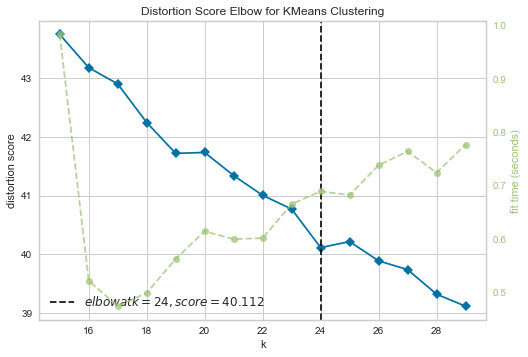

In [23]:
visualizer = KElbowVisualizer(KMeans(), k=(15, 30), metric='distortion')
visualizer.fit(X_proj)
visualizer.show() 

Observando o gráfico acima escolhemos $k=20$

In [24]:
k = 20
kmeans = KMeans(n_clusters=k).fit(X_proj)

Projetando os pontos no espaço de visualização via __TSNE__:

In [25]:
start_time = time.time()
X_tsne = TSNE(n_components=2).fit_transform(X_proj)
interval_time = time.time() - start_time

Tempo de execução:

In [26]:
print('%s segundos' % interval_time)

12.227086782455444 segundos


Gráfico de dispersão dos pontos:

In [27]:
color_palette = Category20[k]

In [28]:
def scatter_plot(X, labels):
    scatter_plot = figure(plot_width=1000, plot_height=500)
    scatter_plot.circle(X[:, 0], X[:, 1], size=10, line_color=[color_palette[l] for l in labels], fill_color=[color_palette[l] for l in labels], fill_alpha=.8)
    show(scatter_plot)

scatter_plot(X_tsne, kmeans.labels_)

Projetando os pontos no espaço de visualização via __UMAP__:

In [29]:
start_time = time.time()
X_umap = umap.UMAP().fit_transform(X_proj)
interval_time = time.time() - start_time

Tempo de execução:

In [30]:
print('%s segundos' % interval_time)

13.931499242782593 segundos


In [31]:
scatter_plot(X_umap, kmeans.labels_)

Agora vamos descobrir as palavras mais relevantes de cada grupo (considerando um único tópico em cada grupo):

In [32]:
dataset['label'] = kmeans.labels_

In [33]:
def get_top_words(topic, n, words, algorithm):
        sorted_idxs = numpy.argsort(algorithm.components_[topic])
        top_words = [words[i] for i in sorted_idxs]
        return [w for w in reversed(top_words[-n:])]

def cluster_topic(dataset, cluster_label, n_words):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(dataset[dataset['label'] == cluster_label].processed_text)
    nmf = NMF(n_components=1)
    X_topics = nmf.fit_transform(X)
    return get_top_words(0, n_words, vectorizer.get_feature_names(), nmf)

In [34]:
n_words = 10
display(HTML('<h2>Top {} palavras de cada grupo</h2>'.format(n_words)))
for label, color in enumerate(color_palette):
    display(HTML('<h3><span style="color:{}"><strong>Grupo {}: {}</strong></span></h3>'.format(color, label, ', '.join(cluster_topic(dataset, label, n_words)))))

c:\users\hugog\ecom063-pln\env\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
